In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: [Monday, Mar 10, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative)**

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

<div class="alert alert-info">

## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W2/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

</div>

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [96]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


plt.rcParams["font.size"] = 16


from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model, X_train,  y_train

    Returns
    ----------
    pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

I chose the NYC Airbnb data set to do my analysis on. My initial thoughts of this data set, in terms of using it to predict reviews per month, are that there are four categories of features: location features (neighborhood, longitude, latitude), host-related features (host_id, host_name), listing features (price, room_type, minimum_nights), and review metrics (number_reviews, last_review). To do a regression analysis on this data set, there is definitely some data cleaning like handling nulls/outliers and feature engineering like transforming categorical variables to do beforehand. A linear regression model will definitely be used.

In [47]:
airbnb_df = pd.read_csv("AB_NYC_2019.csv")
airbnb_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [48]:
train_df, test_df = train_test_split(airbnb_df, test_size = 0.3, random_state=123)

X_train = train_df.drop(columns="reviews_per_month")
y_train = train_df["reviews_per_month"]
X_test = test_df.drop(columns="reviews_per_month")
y_test = test_df["reviews_per_month"]

print (train_df.shape)
print (test_df.shape)

(34226, 16)
(14669, 16)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

In [49]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 34226 entries, 36150 to 15725
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34216 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34209 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     2

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.422600e+04,3.422600e+04,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,27236.000000,34226.000000,34226.000000
mean,1.893979e+07,6.726273e+07,40.729142,-73.952083,151.528399,7.094957,23.244814,1.369816,7.042453,112.526004
std,1.101332e+07,7.840511e+07,0.054531,0.046201,236.628392,21.548290,44.573323,1.700737,32.590803,131.420031
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.394482e+06,7.721897e+06,40.690193,-73.983030,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.954546e+07,3.074526e+07,40.723240,-73.955550,106.000000,3.000000,5.000000,0.710000,1.000000,45.000000
75%,2.915085e+07,1.068375e+08,40.763287,-73.936270,175.000000,5.000000,23.000000,2.000000,2.000000,225.750000
max,3.648561e+07,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [50]:
missing_vals = list(train_df.columns[train_df.isnull().any()])
missing_vals

['name', 'host_name', 'last_review', 'reviews_per_month']

<b> 2. Summary Statistics

Price: 
- The mean price was \\$151.53, which is considerably higher than the median (50th percentile) price at \\$106, indicating that the distribution is skewed to the right and its high standard deviation (236.63) value despite its relatively appropriate interquartile range suggests that it has extreme, high outliers (like its max value of \\$10000)

Minimum Nights:
- The minimum nights distribution is interesting as well because its mean of 7.09 nights is also considerably higher than its median 3 nights, suggesting a rightward skew in its distribution as well. This is further indicated by its max value of 1250 nights which is over a 3 year stay at an Airbnb, this seems like an extremely high outlier as well.

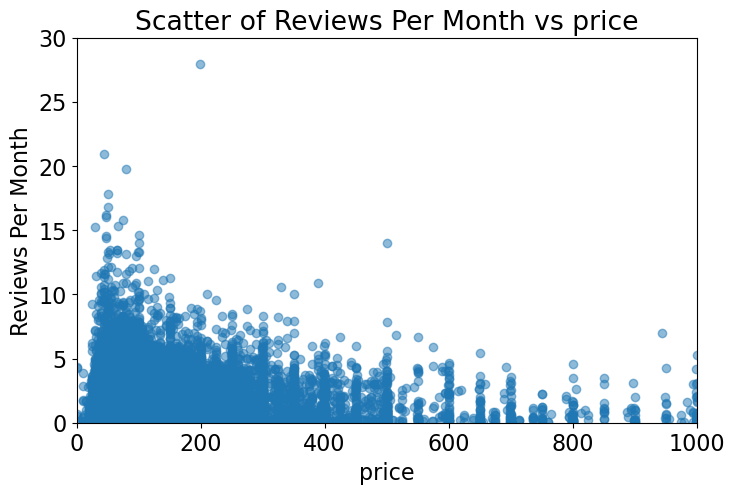

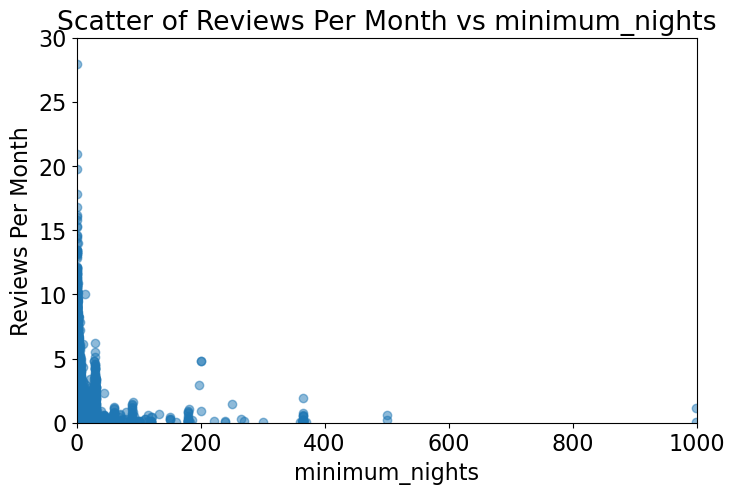

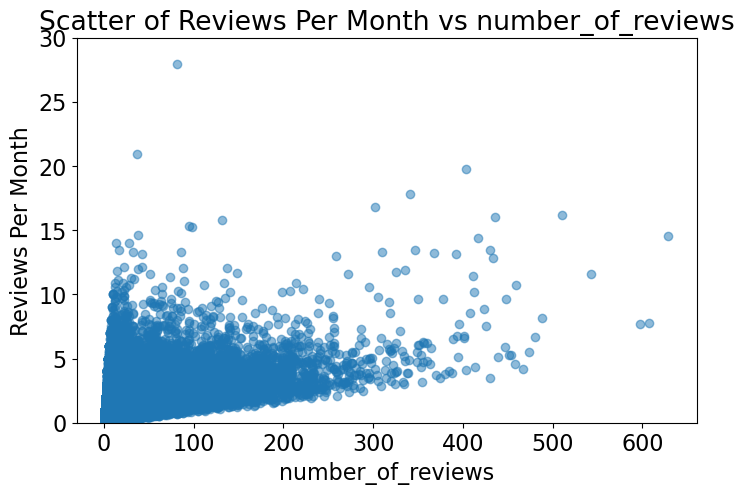

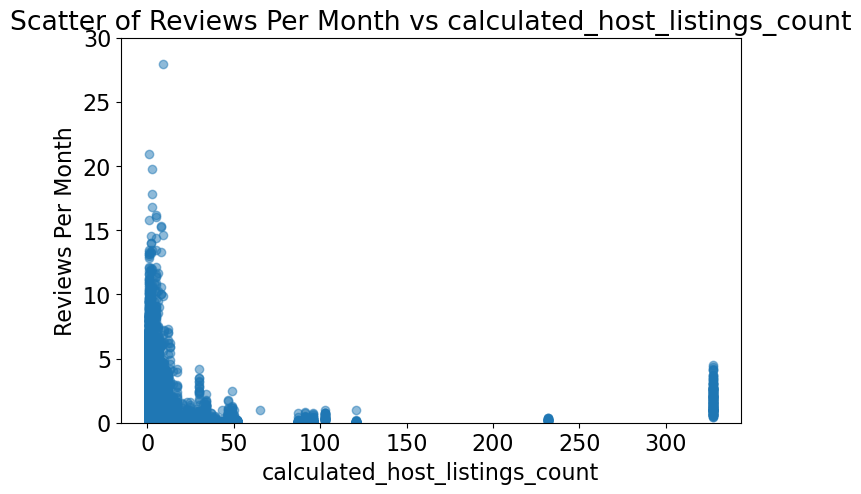

In [51]:
cols_to_plot = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']
for feat in cols_to_plot:
    plt.figure(figsize = (8, 5))
    plt.scatter(train_df[feat], train_df["reviews_per_month"], alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Reviews Per Month")
    plt.title("Scatter of Reviews Per Month vs " + feat)
    if train_df[feat].max() > 1000: #To account for extremely high price values only without affecting other plots
        plt.xlim(0, 1000)
    plt.ylim(0, 30) #To avoid very few higher points making the plot difficult to interpret
    plt.show()

<b> Analysis of Plots:

I plotted reviews per month against each variable I thought to be of interest (would affect reviews per month) and capped reviews per month at 30 so that the few values above 30 wouldn't stretch the plot so much.

1. <b>Price:</b> Firstly, I capped the X axis (price) to 1000 so that the plot wouldn't be so heavily skewed by extremely high outliers. The scatter plot itself shows a decently consistent inverse relationship between price and reviews per month. Listings below $200 seem to have higher reviews per month with a steady decline in reviews per month as price increases. This suggests that more affordable listings attract more guests compared to expensive listings and that price will be an important factor to consider in our problem. It is important to not that there are far more listings in the more affordable range than expensive ones which may play a part in affordable listings getting more reviews.
2. <b>minimum_nights:</b> minimum_nights shows a similar inverse relationship with reviews per month as price does, with reviews per month declining as minimum_nights increases. This suggests that less restriction on how long customers must stay will increase reviews per month/popularity. Of course, the values of minimum_nights are much more compact (more listings) at the lower values (~0 - 100) which could be an important reason as to why these listings seem to get more reviews.
3. <b>number_of_reviews:</b> Number of reviews shows an interesting relationship. The minimum value for reviews per month, of course, increases for each value of number of reviews because more reviews total has to mean more reviews per month. However, the trend across most listings (ignoring the scattered values for higher total reviews >300), the reviews per month seems to decrease slightly as total reviews increases.
4. <b>calculated_host_listings:</b> There is a inverse relationship between calculated host listings and reviews per month, with a slight, sudden bump at ~330 listings, creating a heavy rightward skew. A majority of points are between 0 - 50 host listings which could contribute to why lower host listings have higher reviews per month. 



<b> 3. Initial Observations:

(Feature distributions and relationships above)

There are a handful features with missing values (name, host_name, last_review, reviews_per_month) as well as features with extreme outliers (price, minimum_nights) that need to be handled before an effective regression model can be made. Additionally, categorical features like room_type or neighbourhood need encoding as well. 

<b> 4. Appropriate Metrics

- <b> Root Mean Squared Error (RMSE) </b>: The primary evaluation metric as it penalizes larger errors, making it effective in handling outliers in reviews_per_month. Since RMSE gives a score in the same unit as the target variable, it is also easy to interpret.
- <b> Mean Squared Error (MSE) </b>: Useful during initial model evaluation to compare performance across models. However, its squared error units make it harder to interpret than RMSE or MAE
- <b> Mean Absolute Percentage Error (MAPE) </b>: Provides information regarding relative errors across different listing types before transformations. However, it can become unreliable due to zero values in reviews_per_month.
- <b> Mean Absolute Error (MAE) </b>: Represents the average absolute difference between predicted and actual values. It is intuitive and less sensitive to extreme values compared to RMSE, offering a more balanced measure of accuracy, but could underestimate the impact of large errors.
- <b>$R^2$ Score</b>: Measures how well the model explains the variance in reviews_per_month. This is useful as a supplementary metric, it should be interpreted cautiously due to data skewness and used along with RMSE and MAE for a more reliable assessment.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

I think a `price_per_night` would be a good feature to add. Due to the extreme values some listings have for minimum_nights, judging strictly based off the price feature wouldn't give us a good representation of real affordability (per night). Thus, I will create `price_per_night` so that longer duration stays don't hinder the fairness of price comparisons across listings.

In [52]:
X_train["price_per_night"] = X_train["price"] / X_train["minimum_nights"]
X_train

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,price_per_night
36150,28736148,Cozy 1 Bedroom Apt in Hamilton Heights,43431867,Tommy,Manhattan,Washington Heights,40.83256,-73.94440,Entire home/apt,96,4,0,NaN,1,17,24.000000
45223,34613254,Amazing One Bedroom at the Time Square Area/72B,48146336,Irina,Manhattan,Hell's Kitchen,40.76134,-73.99299,Entire home/apt,150,30,0,NaN,20,332,5.000000
14316,11144496,"New Spacious Master, Williamsburg",48819868,Nick,Brooklyn,Williamsburg,40.71119,-73.95097,Private room,200,1,0,NaN,1,0,200.000000
1691,766814,Adorable Midtown West Studio!,4022922,Caitlin,Manhattan,Hell's Kitchen,40.75900,-73.99530,Entire home/apt,95,1,0,NaN,1,0,95.000000
20195,16162621,NEW! Exceptional 2BR/1BA Williamsburg Oasis,104781467,Russell,Brooklyn,Williamsburg,40.71306,-73.94856,Entire home/apt,199,3,1,2016-12-11,1,0,66.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,5885201,SUNNY ROOM A IN CHARMING AREA :),4291007,Graham And Ben,Brooklyn,Bedford-Stuyvesant,40.69363,-73.95980,Private room,95,30,40,2019-06-01,11,331,3.166667
15377,12325045,IDEAL One bedroom apt by Central Park!,66501870,K Alexandra,Manhattan,Midtown,40.76016,-73.96910,Entire home/apt,139,2,132,2019-06-30,1,154,69.500000
17730,13915004,"Sunlit, spacious NY apartment",7177483,Dani,Manhattan,Harlem,40.80380,-73.95569,Entire home/apt,250,3,10,2019-01-01,1,0,83.333333
28030,21897845,One room.,159769278,Musieka,Bronx,Pelham Gardens,40.86706,-73.84674,Private room,40,2,17,2019-06-04,1,17,20.000000


<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<!-- END QUESTION -->

<br><br>

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

We drop ["id", "name", "host_id", "host_name", "last_review", "number_of_reviews"]. id and host_id are unique identifiers that aren't relevant for predictions/generalizations. host_name is text data that would need to be converted to numeric values, but it's also not very relevant and name is unstructured text that would be both hard to deal with and add little value. Most importantly, I opted to drop number of reviews because I thought it would cause some sort of data leakage induced overfitting causing our model to perform worse.

In [53]:
drop_features = ["id", "name", "host_id", "host_name", "last_review", "number_of_reviews"]

numerical_features = ["price", "price_per_night", "minimum_nights", "availability_365", "calculated_host_listings_count"]

categorical_features = ["room_type", "neighbourhood_group", "neighbourhood"]

pass_features = ["latitude", "longitude"]

In [54]:
#Check for any null values in what we want to keep in our training features
print(X_train[categorical_features].isnull().sum())
print(X_train[numerical_features].isnull().sum())
print(X_train[pass_features].isnull().sum())

room_type              0
neighbourhood_group    0
neighbourhood          0
dtype: int64
price                             0
price_per_night                   0
minimum_nights                    0
availability_365                  0
calculated_host_listings_count    0
dtype: int64
latitude     0
longitude    0
dtype: int64


In [55]:
#Check for any null target values in our training set
print(y_train.isnull().sum())
print(y_train.shape)

6990
(34226,)


In [56]:
#y_train missing over 20% so impute values with median (mean would be affected by outliers)
y_train = y_train.fillna(y_train.median())
print(y_train.isnull().sum())

0


In [58]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features), #Standardize numeric values
    (OneHotEncoder(handle_unknown="ignore"), categorical_features), #No inherent order in categorical features
    ("passthrough", pass_features),
    ("drop", drop_features),
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['price', 'price_per_night', 'minimum_nights',
                                  'availability_365',
                                  'calculated_host_listings_count']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['room_type', 'neighbourhood_group',
                                  'neighbourhood']),
                                ('passthrough', 'passthrough',
                                 ['latitude', 'longitude']),
                                ('drop', 'drop',
                                 ['id', 'name', 'host_id', 'host_name',
                                  'last_review', 'number_of_reviews'])])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [60]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_pipe = make_pipeline(preprocessor, dummy_regressor)

pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.116719,0.006030,-0.000002,0.0
1,0.036189,0.005334,-0.000094,0.0
2,0.030372,0.005285,-0.000366,0.0
3,0.034385,0.005736,-0.000053,0.0
4,0.032212,0.006498,-0.000204,0.0
5,0.029466,0.006112,-0.000431,0.0
6,0.030764,0.005686,-0.000101,0.0
7,0.028234,0.005470,-0.000002,0.0
8,0.028904,0.005262,-0.000408,0.0
9,0.027950,0.006023,-0.002622,0.0


The train ($R^2$) score is always 0, which is expected because the DummyRegressor simply predicts the mean of the training set each time. This captures none of the variance.

The test score is just below 0, meaning the model is doing just a little bit worse than predicting the test fold's mean for each fold. This happens because the mean of the training set does not perfectly match the mean of each test fold, leading to a small negative $R^2$.

Any other real model should produce a score closer to one than this baseline.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [93]:
#Use Ridge linear model
lr_pipe = make_pipeline(preprocessor, Ridge())

initial_results = pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))
mean_test_score = np.mean(initial_results["test_score"])
print(mean_test_score)
initial_results

0.09675331163976467


,fit_time,score_time,test_score,train_score
0,0.173021,0.006635,0.109339,0.110726
1,0.138514,0.008823,0.113461,0.110364
2,0.133426,0.009742,0.110637,0.110624
3,0.118371,0.006341,0.091926,0.112501
4,0.122001,0.005461,0.071781,0.116294
5,0.123733,0.005618,0.081817,0.113775
6,0.114953,0.005950,0.104932,0.111195
7,0.123684,0.005478,0.094764,0.112379
8,0.118918,0.005741,0.120555,0.109185
9,0.119415,0.005729,0.068322,0.114506


Initial model performance is poor with a mean score of 0.09675 and a notable amount of variance in the test score so we should try tuning alpha.

Text(0, 0.5, 'score')

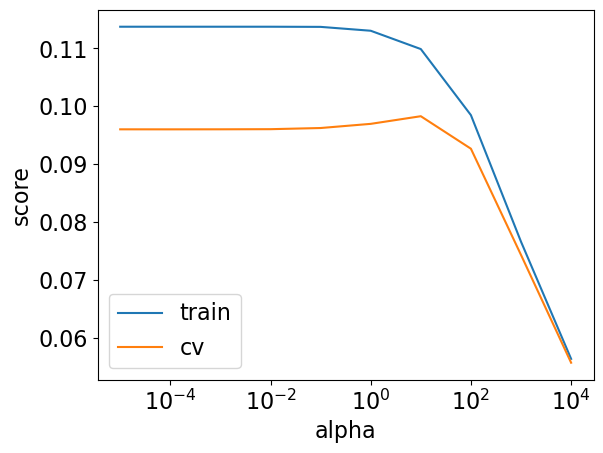

In [94]:
param_grid = {"ridge__alpha": 10.0 ** np.arange(-5, 5, 1)}
newPipe_ridge = make_pipeline(preprocessor, Ridge())

#First Grid Search
gs = GridSearchCV(newPipe_ridge, param_grid, return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)

# Extract train and cross-validation scores
train_scores = gs.cv_results_["mean_train_score"]
cv_scores = gs.cv_results_["mean_test_score"]

#Plot of mean train and cv scores against alpha
plt.semilogx(param_grid["ridge__alpha"], train_scores.tolist(), label="train")
plt.semilogx(param_grid["ridge__alpha"], cv_scores.tolist(), label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score")

In [95]:
#Summary of CV and std scores
cv_results = pd.DataFrame({
    "alpha": gs.cv_results_["param_ridge__alpha"],
    "mean_train_score": gs.cv_results_["mean_train_score"],
    "std_train_score": gs.cv_results_["std_train_score"],
    "mean_test_score": gs.cv_results_["mean_test_score"],
    "std_test_score": gs.cv_results_["std_test_score"],
})

#Put in ascending alpha
cv_results.sort_values(by="alpha", inplace=True)

print(gs.best_params_)
cv_results

{'ridge__alpha': 10.0}


,alpha,mean_train_score,std_train_score,mean_test_score,std_test_score
0,0.00001,0.113759,0.003474,0.096024,0.011759
1,0.00010,0.113759,0.003474,0.096020,0.011757
2,0.00100,0.113759,0.003474,0.096027,0.011759
3,0.01000,0.113758,0.003474,0.096049,0.011760
4,0.10000,0.113733,0.003473,0.096250,0.011781
5,1.00000,0.113063,0.003444,0.096969,0.011842
6,10.00000,0.109897,0.003334,0.098290,0.011304
7,100.00000,0.098479,0.002879,0.092674,0.009290
8,1000.00000,0.076600,0.001959,0.074316,0.006111
9,10000.00000,0.056350,0.001046,0.055683,0.003516


It seems that the best `alpha` score is <b>10</b>, achieving a mean test score of 0.098290 and a standard deviation of 0.011304. Although this is slightly better than the baseline DummyRegressor, even with hyperparameter tuning, this result isn't very good and is quite a low score. Perhaps the features aren't predictive enough, or Ridge isn't the best choice, regardless, we should try other models.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

In [102]:
#First create dictionary to store result from all different models
results = {}

#Add Dummy and Ridge
results["dummy"] = mean_std_cross_val_scores(
    dummy_pipe, X_train, y_train, return_train_score=True
)
results["Ridge"] = mean_std_cross_val_scores(
    lr_pipe, X_train, y_train, return_train_score=True
)

/var/folders/cd/vcj8l6853d195376zswvw4_c0000gn/T/ipykernel_96172/3401527558.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/cd/vcj8l6853d195376zswvw4_c0000gn/T/ipykernel_96172/3401527558.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


<b>METHOD 1: Gradient Boosted Trees

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

pipe = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=123))

results["GradientBoostingRegressor"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

/var/folders/cd/vcj8l6853d195376zswvw4_c0000gn/T/ipykernel_96172/3401527558.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.035 (+/- 0.023),0.008 (+/- 0.001),-0.000 (+/- 0.000),0.000 (+/- 0.000)
Ridge,0.113 (+/- 0.006),0.008 (+/- 0.001),0.097 (+/- 0.013),0.113 (+/- 0.004)
GradientBoostingRegressor,3.272 (+/- 0.045),0.017 (+/- 0.001),0.332 (+/- 0.025),0.364 (+/- 0.006)


<b>METHOD 2: Random Forest Regressor

In [108]:
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(preprocessor, RandomForestRegressor(random_state=123))

results["RandomForestRegressor"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

/var/folders/cd/vcj8l6853d195376zswvw4_c0000gn/T/ipykernel_96172/3401527558.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.035 (+/- 0.023),0.008 (+/- 0.001),-0.000 (+/- 0.000),0.000 (+/- 0.000)
Ridge,0.113 (+/- 0.006),0.008 (+/- 0.001),0.097 (+/- 0.013),0.113 (+/- 0.004)
GradientBoostingRegressor,3.272 (+/- 0.045),0.017 (+/- 0.001),0.332 (+/- 0.025),0.364 (+/- 0.006)
RandomForestRegressor,95.592 (+/- 1.455),0.229 (+/- 0.013),0.344 (+/- 0.030),0.907 (+/- 0.002)


<b>METHOD 3: KNeighborsRegressor

In [109]:
from sklearn.neighbors import KNeighborsRegressor

pipe = make_pipeline(preprocessor, KNeighborsRegressor())

results["KNeighborsRegressor"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

/var/folders/cd/vcj8l6853d195376zswvw4_c0000gn/T/ipykernel_96172/3401527558.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.035 (+/- 0.023),0.008 (+/- 0.001),-0.000 (+/- 0.000),0.000 (+/- 0.000)
Ridge,0.113 (+/- 0.006),0.008 (+/- 0.001),0.097 (+/- 0.013),0.113 (+/- 0.004)
GradientBoostingRegressor,3.272 (+/- 0.045),0.017 (+/- 0.001),0.332 (+/- 0.025),0.364 (+/- 0.006)
RandomForestRegressor,95.592 (+/- 1.455),0.229 (+/- 0.013),0.344 (+/- 0.030),0.907 (+/- 0.002)
KNeighborsRegressor,0.041 (+/- 0.011),5.597 (+/- 0.358),0.192 (+/- 0.034),0.467 (+/- 0.007)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)